# Visualize CAMs

In [8]:
import tensorflow_datasets as tfds

mnist_data, mnist_info = tfds.load('mnist', with_info=True)

In [9]:
import numpy as np

mnist_train_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['train'])])
mnist_train_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['train'])])

mnist_test_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['test'])])
mnist_test_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['test'])])

In [10]:
image_shape = mnist_train_x[0].shape
image_shape

(28, 28, 1)

## Load model c3

In [11]:
import tensorflow as tf

model_name_c3 = "model_c3"
model_c3 = tf.keras.Sequential(name = model_name_c3)
model_c3.add(tf.keras.layers.Input(image_shape))
model_c3.add(tf.keras.layers.Conv2D(filters = 16, 
                                    kernel_size = (3,3),
                                    activation="relu", 
                                    padding="same", 
                                    name="convolution_1"))
model_c3.add(tf.keras.layers.Conv2D(filters = 16, 
                                    kernel_size = (3,3),
                                    activation="relu", 
                                    padding="same", 
                                    name="convolution_2"))
model_c3.add(tf.keras.layers.Conv2D(filters = 16, 
                                    kernel_size = (3,3),
                                    activation="relu", 
                                    padding="same", 
                                    name="convolution_3"))
model_c3.add(tf.keras.layers.Conv2D(filters = 16, 
                                    kernel_size = (3,3),
                                    activation="relu", 
                                    padding="same", 
                                    name="convolution_4"))
model_c3.add(tf.keras.layers.Conv2D(filters = 256, 
                                    kernel_size = (3,3),
                                    activation="relu", 
                                    padding="same", 
                                    name="convolution_5"))
model_c3.add(tf.keras.layers.GlobalAveragePooling2D(name = "GAP"))
model_c3.add(tf.keras.layers.Dense(10, 
                                   activation='softmax', 
                                   name='output',
                                   use_bias = False))
model_c3.compile(loss='sparse_categorical_crossentropy', 
                 optimizer='Adam', 
                 metrics=['accuracy'])
model_c3.load_weights("model_c3/model_c3.h5")

In [12]:
# _, train_acc = model_c3.evaluate(mnist_train_x, mnist_train_y)
# print('Train accuracy: {}'.format(train_acc))
# _, test_acc = model_c3.evaluate(mnist_test_x, mnist_test_y)
# print('Test accuracy: {}'.format(test_acc))

# Plot examples

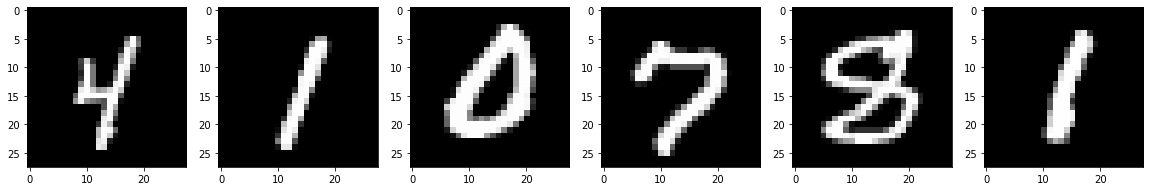

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 6, figsize = (20,6))
for i in range(len(axs)):
    axs[i].imshow(mnist_train_x[i], cmap = plt.get_cmap("gray"))
plt.show()

# Get Class Activation Maps!

In [14]:
get_last_conv_output = tf.keras.backend.function([model_c3.layers[0].input], [model_c3.layers[-3].output])
last_matrix = model_c3.weights[-1]

def get_CAM(example, i = None):
    example = example.reshape(1,28,28,1)
    y_pred = np.argmax(model_c3(example)[0])
    if i is None:
        i = y_pred
    maps = get_last_conv_output(example)[0].reshape(28,28,256)
    w = last_matrix[:,i]
    for j in range(w.shape[0]):
        maps[:,:,j] = w[j] * maps[:,:,j]
    return np.sum(maps, axis = 2), y_pred

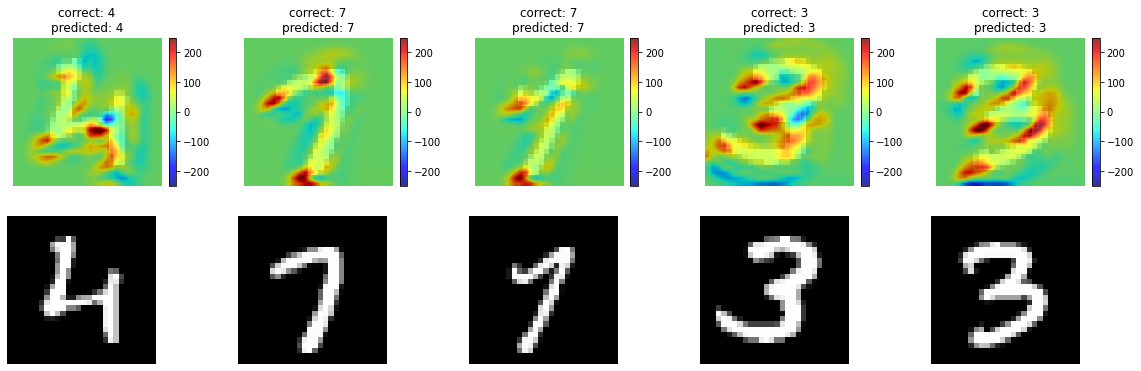

In [15]:
template = "correct: {}\npredicted: {}"

fig, axs = plt.subplots(2, 5, figsize = (20,6))
for i in range(axs.shape[1]):
    j            = i+11
    example      = mnist_train_x[j]
    y            = mnist_train_y[j]
    map_, y_pred = get_CAM(example)
    axs[0][i].imshow(example, cmap = plt.get_cmap("gray"))
    axs[1][i].imshow(example, cmap = plt.get_cmap("gray"))
    img          = axs[0][i].imshow(map_, cmap = "jet", alpha = 0.8, interpolation = "bilinear", vmin = -250, vmax = 250)
    axs[0][i].set_title(template.format(y, y_pred))
    axs[0][i].axis("off")
    axs[1][i].axis("off")
    fig.colorbar(img, ax = axs[0][i], fraction = 0.046, pad = 0.04)
plt.show()